In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image as Image
import cv2
import os, io
import PIL
import gcsfs
from cv2 import GaussianBlur
import random
from skimage.util import random_noise
import skimage.io
import skimage.filters
from matplotlib.colors import LogNorm
from scipy import fftpack
import pandas as pd
from tqdm import tqdm

#extensible 
noise_type = ['gauss','poisson', 'speckle']

def noisy(noise_typ,image):
    if noise_typ == "gauss":
        return cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
    
    
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals)) 
        return np.random.poisson(image * vals) / float(vals)
    
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        return image + (image * gauss * 0.08)



def img_from_uri(contents): 
    img = []
    for content in tqdm(contents):
        
        if 'gs://' in content:
            uri = content
        else:
            uri = 'gs://' + content

        with tf.io.gfile.GFile(uri, "rb") as f:
             byte = f.read()

        im = Image.open(io.BytesIO(byte)).convert('L')
        img.append(np.array(im))


    return img


def plot_spectrum(im_fft):
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

    
# A function that given an image in frequency space, returns the noise
# avoiding the good signal
def get_noise_fourier(img_fft, treshold = 0.1 ):  
    r, c = img_fft.shape
    
    img_fft[int(r*(treshold)):int(r*(1-treshold))]  = 0
    img_fft[:, int(c*(treshold)):int(c*(1-treshold))]  = 0
    
    img_fft[int(r*(-1*treshold)):int(r*(1+treshold))]  = 0
    img_fft[:, int(c*(-1*treshold)):int(c*(1+treshold))]  = 0
   
    return img_fft



def compute_fourier_mult_img(img_list):
    img_list_fft = []
    
    for img in img_list: 
        img_list_fft.append(fftpack.fft2(img))
    
    return img_list_fft

normalize = lambda x: (x - x.min())/(x.max() - x.min())


def show_noise(noise):
    #noise = fftpack.ifft2(noise).real
    plt.figure()
    plt.imshow(noise, plt.cm.gray)
    plt.title('Reconstructed Noise')
    

def pad_noise(noise_target, pad_width, mode = 'wrap'):
    noise_target = fftpack.ifft2(noise_target).real    
    return np.pad(noise_target, pad_width = pad_width, mode = mode)


def plot_results(clear, noised):
    num = 3
    fig = plt.figure(figsize=(15,20))
    rows = 2
    columns = 3
    
    fig.add_subplot(rows, columns, 1)
    plt.imshow(clear,plt.cm.gray)
    plt.axis('off')
    plt.title("Original Test")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(noised,plt.cm.gray)
    plt.axis('off')
    plt.title("Test with Fourier Perturbation")

    fig.add_subplot(rows, columns, 3)
    plt.imshow(noisy('speckle',noised),plt.cm.gray)
    plt.axis('off')
    plt.title("Test with Fourier Perturbation + Gauss noise")

    
def read_image(uri): 
    
    with gcsfs.GCSFileSystem().open(uri, "rb") as f:
         byte = f.read()
            
    pil_img = Image.open(io.BytesIO(byte)).convert('L')

    return np.array(pil_img)


Get target and images to perturbate 

In [2]:
contents_target = gcsfs.GCSFileSystem().ls("gs://marco-aspromonte-denoising/data/sample/images/crops")

In [3]:
X_test = img_from_uri(contents_target) #Import test samples 

100%|██████████| 5/5 [00:00<00:00,  6.28it/s]


In [6]:
pd_query = pd.read_gbq("SELECT PCN.URL,PD.crop_image_path FROM formazione-marco-aspromonte.denoising.platesmania_crops_noised  AS PCN JOIN formazione-marco-aspromonte.denoising.platesmania_dataset AS PD ON PD.crop_uuid=PCN.ID ")
contents = pd_query.crop_image_path

for uri in contents:
    y_test.append(read_image(uri))

NameError: name 'y_test' is not defined

In [54]:
len(contents)

26495

In [11]:
# Let's return the list of spectrums transformed with FFT
X_test_fft = compute_fourier_mult_img(X_test) #sinelec

In [12]:
# Now we can extract the noise for each target sample, in order to define a list of noises of the target
noises_from_targets = []
for x_fft in X_test_fft:
    noises_from_targets.append(get_noise_fourier(x_fft, treshold = 0.03)) #0.003 for naturals 0.0015

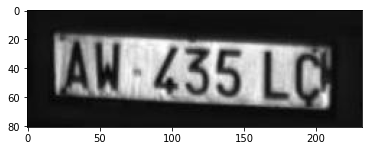

In [13]:
#Let's choose the test and the noise
y = y_test[5]
noise = noises_from_targets[2]
plt.imshow(X_test[2], plt.cm.gray)

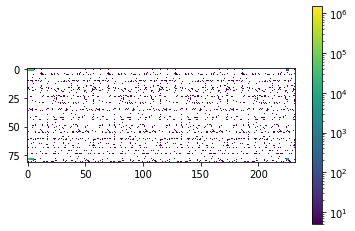

In [29]:
# Here an example of the plotted spectrum for a given noise type
plot_spectrum(noise)

(81, 232)

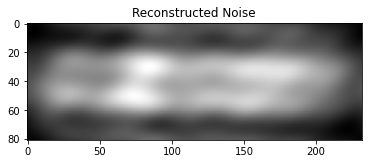

In [18]:
# Compute the inverse of the FFT wrt the noise in order to return in pixels' space and have a 
# graphical representation of the noise
noise_img = fftpack.ifft2(noise).real
plt.figure()
plt.imshow(noise_img, plt.cm.gray)
plt.title('Reconstructed Noise')
noise_img.shape

In [19]:
noise_img.min()

24.15942395133431

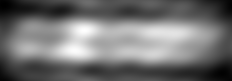

In [23]:
img = Image.fromarray(adapt_to_pil(noise_img).astype(np.uint8))
img

We need to pad the noise in order to match the shapes between the noise target and the sample to perturbate

In [72]:
# Compute the pad_width with respect to the shapes along x and y; the pad mode can be changed, in this case i decided to use wrap
# in order to fill all the noise space with acceptable values; also symmetric is interesting
# THIS IS THE PADDING IF WE ADMIT THE DIMENSION OF IMAGE GREATER THEN THE NOISEà
#pad_width = ((y.shape[0] - noise.shape[0] , 0), 
 #           (y.shape[1] - noise.shape[1] , 0))

#noise_padded = pad_noise(noise, pad_width , mode = 'median')

In [25]:
# We don't need the padding if the noise is greater, we match the shape by removing pieces of noise
noise_real = fftpack.ifft2(noise).real
#noise_crop = noise_real[0:y.shape[0],0:y.shape[1]]

In [26]:
noise_padded = cv2.resize(noise_real, dsize=(y.shape[1], y.shape[0]), interpolation=cv2.INTER_CUBIC)

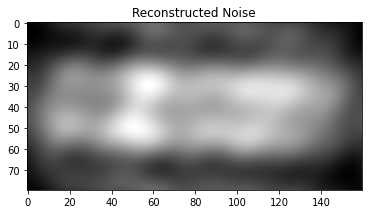

In [27]:
show_noise(noise_padded)

In [28]:
# Normalization not often needed but reccomended, we have to evaluate the consequences
noise = normalize(noise_padded)
y = normalize(y)

In [29]:
# Now, let's simply sum the noise with the originary sample divided by an arbitrary sum in order to tune the strenght of noise
test_noise = y*0.5 + (noise)*0.5

In [30]:
test_noise.max()

0.9084689224206877

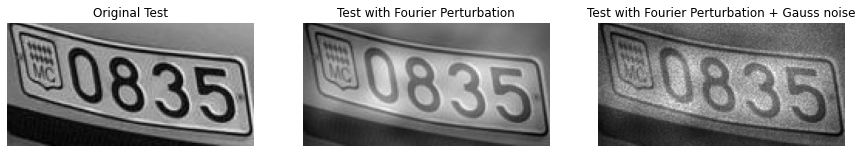

In [51]:
plot_results(y, test_noise)

In [9]:
adapt_to_pil = lambda x:((x - x.min()) * (1/(x.max() - x.min()) * 255)).astype('uint8')
test_noise = adapt_to_pil(noisy(noise_type[random.randint(0,1)],test_noise))

NameError: name 'test_noise' is not defined

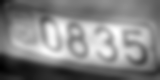

In [252]:
img = Image.fromarray(test_noise)
img

In [5]:
import gcsfs

def gcs_ls(uri):
    return ['gs://' + content for content in gcsfs.GCSFileSystem().ls(uri)]

gcs_source_folder = "gs://marco-aspromonte-denoising/data/sample/images/crops"
query = "SELECT * FROM formazione-marco-aspromonte.denoising.platesmania_dataset"

uris_target = gcs_ls(gcs_source_folder) 
pd_query = pd.read_gbq(query)
uris_to_perturbe = pd_query.crop_image_path

noise_real = []
imgs_to_perturb = []
imgs_perturbed = []

In [6]:

output_counter = 5
img_perturbed = []

for uri in tqdm(uris_target): 

    img_target = read_image(uri)
    img_fft = fftpack.fft2(img_target)
    noise_from_targets = get_noise_fourier(img_fft, treshold = 0.03)
    noise_real.append(fftpack.ifft2(noise_from_targets).real)


for idx, uri in tqdm(enumerate(uris_to_perturbe)):

    if(idx <= int(output_counter)):
        img_to_perturb = (read_image(uri))

        noise_real_interpolated = cv2.resize(noise_real[random.randint(0,len(noise_real)-1)], dsize=(img_to_perturb.shape[1], 
                                            img_to_perturb.shape[0]), interpolation=cv2.INTER_CUBIC)

        img_perturbed = (normalize(img_to_perturb)*0.5 + normalize(noise_real_interpolated)*0.5)





100%|██████████| 5/5 [00:00<00:00, 25.56it/s]
26495it [00:00, 56536.27it/s]


In [7]:
img_perturbed = adapt_to_pil(img_perturbed)

NameError: name 'adapt_to_pil' is not defined

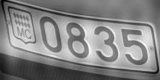

In [240]:
img = Image.fromarray(img_perturbed)
img

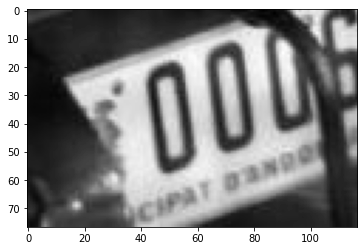

In [84]:
plt.imshow(img_perturbed, plt.cm.gray)